In [143]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

import pandas as pd
import numpy as np
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import yaml
import pypsa

from pypsa.descriptors import Dict
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches

from cartopy import crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from geopandas.tools import geocode

from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

### Load scenario and data

In [101]:
def load_configuration(config_path):
    """
    Load configuration settings from a YAML file.
    """
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    return config


snakemake = Dict()
snakemake.config = load_configuration("../config.yaml")
snakemake.input = Dict()
snakemake.output = Dict()

run = "DKDEPT-1H-allflex-noexcess-nocostshifts-manysteps"  # run name from config.yaml
distance = snakemake["config"]["scenario"]["distance"][0]  # pair name from config.yaml

if True:
    folder = f"/results/{run}"
    scenario = f"/2025/p1/cfe100/{distance}"

    snakemake.input.data = f"{folder}/networks/{scenario}/{distance}/40.nc"
    snakemake.output.plot = f"../manuscript/images/plot.pdf"

    n = pypsa.Network(f"../{folder}/networks/{scenario}/40.nc")

INFO:pypsa.io:Imported network 40.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [102]:
datacenters = snakemake.config["ci"][f"{distance}"]["datacenters"]
locations = list(datacenters.keys())
names = list(datacenters.values())

regions = gpd.read_file("../input/regions_onshore_elec_s_256.geojson")
n_256 = pypsa.Network("../input/elec_s_256_ec.nc")

df = pd.read_csv(f"..{folder}/csvs{scenario}/summary.csv", index_col=0, header=[0, 1])

INFO:pypsa.io:Imported network elec_s_256_ec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


In [103]:
# Wildcards & Settings
config = snakemake.config
policy = "cfe100"
palette = "p1"
zone = snakemake.config["zone"]
year = "2025"
datacenters = config["ci"][f"{distance}"]["datacenters"]
locations = list(datacenters.keys())
names = list(datacenters.values())

flexibilities = snakemake.config["scenario"]["flexibility"]

# techs for CFE hourly matching, extracted from palette
palette_techs = (
    ["onwind", "solar"],
    ["battery"],
    ["battery charger"],
    ["battery discharger"],
)

(
    clean_techs,
    storage_techs,
    storage_charge_techs,
    storage_discharge_techs,
) = palette_techs

# renaming technologies for plotting
clean_chargers = [tech.replace(" ", "_") for tech in storage_charge_techs]
clean_dischargers = [tech.replace(" ", "_") for tech in storage_discharge_techs]

In [128]:
rename_ci_capacity = pd.Series(
    {
        "onwind": "onshore wind",
        "solar": "solar",
        "battery_discharger": "battery",
        "H2_Fuel_Cell": "hydrogen fuel cell",
        "H2_Electrolysis": "hydrogen electrolysis",
        "adv_geothermal": "advanced dispatchable",
        "allam_ccs": "NG-Allam",
    }
)

rename_scen = {
    "0": "0%\n",
    "10": "10%\n",
    "20": "20%\n",
    "30": "30%\n",
    "40": "40%\n",
}

preferred_order = pd.Index(
    [
        "advanced dispatchable",
        "NG-Allam",
        "Gas OC",
        "offshore wind",
        "onshore wind",
        "solar",
        "battery",
        "hydrogen storage",
        "hydrogen electrolysis",
        "hydrogen fuel cell",
    ]
)

rename_ci_cost = pd.Series(
    {
        "onwind": "onshore wind",
        "solar": "solar",
        "grid": "grid imports",
        "revenue": "revenue",
        "battery_storage": "battery",
        "battery_inverter": "battery",
        "battery_discharger": "battery",
        "hydrogen_storage": "hydrogen storage",
        "hydrogen_electrolysis": "hydrogen storage",
        "hydrogen_fuel_cell": "hydrogen storage",
        "adv_geothermal": "advanced dispatchable",
        "allam_ccs": "NG-Allam",
    }
)

In [105]:
tech_colors = snakemake.config["tech_colors"]

### Plots to be used in the dashboard


In [135]:
### Plot 1


def assign_location(n):
    """
    Assign bus location per each individual component
    """
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)
        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1:
                continue
            names = ifind.index[ifind == i]
            c.df.loc[names, "location"] = names.str[:i]


def plot_datacenters_on_europe_map(ax, network, datacenters):

    projection = ccrs.PlateCarree()
    # fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": projection})

    ax.set_extent([-15, 30, 30, 70], crs=ccrs.PlateCarree())

    map_opts = {
        "color_geomap": {
            "ocean": "lightblue",
            "land": "white",
            "border": "black",
            "coastline": "black",
        },
    }

    # Add map features with custom styles
    ax.add_feature(
        cfeature.OCEAN.with_scale("50m"),
        facecolor=map_opts["color_geomap"]["ocean"],
        zorder=0,
    )
    ax.add_feature(
        cfeature.LAND.with_scale("50m"),
        facecolor=map_opts["color_geomap"]["land"],
        zorder=0,
    )
    ax.add_feature(
        cfeature.BORDERS.with_scale("50m"),
        edgecolor=map_opts["color_geomap"]["border"],
        linewidth=0.5,
        alpha=0.5,
        zorder=1,
    )
    ax.add_feature(
        cfeature.COASTLINE.with_scale("50m"),
        edgecolor=map_opts["color_geomap"]["coastline"],
        linewidth=0.5,
        alpha=0.5,
        zorder=1,
    )

    n = network.copy()
    assign_location(n)

    n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)
    n.stores.drop(n.stores[n.stores.index.str.contains("EU")].index, inplace=True)
    n.links.drop(n.links[n.links.carrier == "dsm"].index, inplace=True)

    dc_locations = n.buses.loc[datacenters.keys(), ["x", "y"]]

    ax.scatter(
        dc_locations["x"],
        dc_locations["y"],
        color="darkblue",
        # label="Datacenter locations",
        transform=ccrs.Geodetic(),
        zorder=5,
        s=100,
    )
    ax.set_title("Datacenter locations", fontsize=14)

    connections = set()
    for i, loc1 in dc_locations.iterrows():
        for j, loc2 in dc_locations.iterrows():
            if i < j:  # each pair is considered only once
                ax.plot(
                    [loc1["x"], loc2["x"]],
                    [loc1["y"], loc2["y"]],
                    color="darkblue",
                    linestyle="dotted",
                    alpha=0.8,
                    transform=ccrs.Geodetic(),
                    zorder=4,
                    linewidth=2,
                )

    # Customize the plot
    plt.legend(loc="lower left")

    # fig.tight_layout()
    # fig.savefig(
    #     snakemake.output.plot_DC,
    #     facecolor="white",
    #     dpi=600,
    # )

In [138]:
### Plots 2 and 3


def plot_average_capacity_factor(ax, regions, network, carrier):

    if carrier == "onwind":
        colormap = "viridis"
    if carrier == "solar":
        colormap = "cividis"

    # Extract time series of specified carrier feed-in per region and calculate average
    carrier_data = network.generators_t.p_max_pu.filter(like=carrier).mean()

    # Adjust the renaming to include the full region and sub-region code
    capacity_factors = carrier_data.rename(lambda x: " ".join(x.split()[:-1])).to_frame(
        "average_capacity_factor"
    )

    # Merge using the updated keys
    regions = regions.merge(
        capacity_factors, left_on="name", right_index=True, how="left"
    )

    # fig, ax = plt.subplots(
    #     subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 8)
    # )
    ax.set_extent([-15, 30, 35, 65], crs=ccrs.PlateCarree())

    map_opts = {
        "color_geomap": {
            "ocean": "lightblue",
            "land": "white",
            "border": "black",
            "coastline": "black",
        },
    }

    # Add map features with custom styles
    ax.add_feature(
        cfeature.OCEAN.with_scale("50m"),
        facecolor=map_opts["color_geomap"]["ocean"],
        zorder=0,
    )
    ax.add_feature(
        cfeature.LAND.with_scale("50m"),
        facecolor=map_opts["color_geomap"]["land"],
        zorder=0,
    )
    ax.add_feature(
        cfeature.BORDERS.with_scale("50m"),
        edgecolor=map_opts["color_geomap"]["border"],
        linewidth=0.5,
        alpha=0.5,
        zorder=1,
    )
    ax.add_feature(
        cfeature.COASTLINE.with_scale("50m"),
        edgecolor=map_opts["color_geomap"]["coastline"],
        linewidth=0.5,
        alpha=0.5,
        zorder=1,
    )

    regions.plot(column="average_capacity_factor", ax=ax, legend=True, cmap=colormap)

    if carrier == "onwind":
        _ = "onshore wind"
    if carrier == "solar":
        _ = "solar PV"

    ax.coastlines()
    ax.set_title(f"Annual average capacity factor for {_}", fontsize=14)
    # plt.show()


# plot_average_capacity_factor(regions, n, "onwind")

In [172]:
# plot 4


def format_column_names(col_tuple):
    return f"{col_tuple[0]}{col_tuple[1][:2]}"


def ci_capacity(
    ax, df, tech_colors, rename_scen, rename_ci_capacity, preferred_order, datacenters
):
    # fig, ax = plt.subplots(figsize=(8, 6))

    # Consolidate DataFrame operations
    inventory_frames = [
        df.loc[["ci_cap_" + t.replace(" ", "_") for t in techs]].rename(
            {"ci_cap_" + t: t for t in techs}
        )
        for techs in [clean_techs, clean_dischargers, clean_chargers]
    ]
    ldf = pd.concat(inventory_frames)
    ldf = ldf.drop(["battery_charger"])  # Exclude battery charger capacity

    # Drop rows with all values less ran 0.1
    ldf = ldf.drop(ldf.index[(ldf < 0.1).all(axis=1)])

    # Rename columns and indices, and reorder DataFrame
    ldf.rename(columns=rename_scen, level=0, inplace=True)
    ldf.rename(index=rename_ci_capacity, level=0, inplace=True)
    new_index = preferred_order.intersection(ldf.index).append(
        ldf.index.difference(preferred_order)
    )
    ldf = ldf.loc[new_index].sort_index(
        axis="columns", level=[1, 0], ascending=[False, True]
    )

    # Plotting
    if not ldf.empty:
        ldf.T.plot(
            kind="bar",
            stacked=True,
            ax=ax,
            color=tech_colors,
            width=0.65,
            edgecolor="black",
            linewidth=0.05,
        )
        ax.set_xticklabels(
            [format_column_names(col) for col in ldf.columns.tolist()], fontsize=12
        )
        plt.xticks(rotation=0)
        ax.grid(alpha=0.3)
        ax.set_axisbelow(True)
        ax.set_ylim([0, max(ldf.sum()) * 1.3])
        ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))
        ax.set_title("Portfolio capacity for 24/7 CFE matching", fontsize=14)
        ax.set_ylabel("Procured capacity [MW]", fontsize=14)
        ax.legend(loc="upper left", ncol=2, prop={"size": 12})

        # Add datacenter lines
        space = len(ldf.columns) / len(datacenters)
        for l in range(len(datacenters) - 1):
            ax.axvline(x=(space - 0.5) + space * l, color="gray", linestyle="--")
    else:
        print("Dataframe to plot is empty")

    # fig.tight_layout()
    # fig.savefig(snakemake.output.plot, transparent=True)


def ci_costandrev(
    ax, df, tech_colors, rename_scen, rename_ci_cost, preferred_order, datacenters
):
    # fig, ax = plt.subplots(figsize=(8, 6))

    # Define technologies list
    techs = clean_techs + [
        "grid",
        "battery_storage",
        "battery_inverter",
        "hydrogen_storage",
        "hydrogen_electrolysis",
        "hydrogen_fuel_cell",
    ]

    # Calculate costs and handle DataFrame operations
    costs = (
        df.loc[["ci_cost_" + t.replace(" ", "_") for t in techs]]
        .rename({"ci_cost_" + t: t for t in techs})
        .multiply(1 / df.loc["ci_demand_total"], axis=1)
    )
    costs = costs.drop(costs.index[(costs < 0.1).all(axis=1)])

    # Handling revenues
    revenues = -df.loc[["ci_average_revenue"]].rename({"ci_average_revenue": "revenue"})
    ldf = pd.concat([costs, revenues])

    # Rename and Group by rename_ci_cost, then sort
    ldf.rename(columns=rename_scen, level=0, inplace=True)
    ldf = ldf.groupby(rename_ci_cost).sum()
    new_index = preferred_order.intersection(ldf.index).append(
        ldf.index.difference(preferred_order)
    )
    ldf = ldf.loc[new_index].sort_index(
        axis="columns", level=[1, 0], ascending=[False, True]
    )

    # Plotting
    if not ldf.empty:
        ldf.T.plot(
            kind="bar",
            stacked=True,
            ax=ax,
            color=tech_colors,
            width=0.65,
            edgecolor="black",
            linewidth=0.05,
        )
        ax.set_xticklabels(
            [format_column_names(col) for col in ldf.columns.tolist()], fontsize=12
        )
        plt.xticks(rotation=0)
        ax.grid(alpha=0.3)
        ax.set_axisbelow(True)
        ax.set_ylabel("Normalised costs [€$\cdot$MWh$^{-1}$]", fontsize=14)
        ax.set_title("Costs of 24/7 CFE matching", fontsize=14)
        ax.legend(loc="upper left", ncol=3, prop={"size": 12})
        ax.set_ylim(top=max(ldf.sum()) * 1.3)

        # Add net cost markers
        net_costs = ldf.sum()
        for i, cost in enumerate(net_costs):
            ax.scatter(x=i, y=cost, color="black", marker="_")
        ax.scatter([], [], color="black", marker="_", label="net cost")
        ax.legend(loc="upper left", ncol=1, prop={"size": 12})

        # Add datacenter lines
        space = len(ldf.columns) / len(datacenters)
        for l in range(len(datacenters) - 1):
            ax.axvline(x=(space - 0.5) + space * l, color="gray", linestyle="--")
    else:
        print("Dataframe to plot is empty")

    # fig.tight_layout()
    # fig.savefig(
    #     snakemake.output.plot.replace("capacity.pdf", "ci_costandrev.pdf"),
    #     transparent=True,
    # )


def ci_abs_costs(ax, df, rename_scen):
    # fig, ax = plt.subplots(figsize=(6, 4.5))

    # Calculate absolute costs
    ldf = (df.loc["ci_total_cost"] - df.loc["ci_revenue_grid"]) / 1e6
    ldf = ldf.to_frame(name="ci_abs_costs")

    # Refine data
    ldf.index = ldf.index.set_levels(ldf.index.levels[0].map(rename_scen), level=0)
    ldf = ldf["ci_abs_costs"].unstack()
    ldf.sort_index(axis="rows", ascending=True, inplace=True)

    # Update columns for plotting
    ldf.columns = [format_column_names(col) for col in ldf.columns.tolist()]

    # Plotting
    if not ldf.empty:
        ldf.plot(
            kind="bar",
            stacked=True,
            ax=ax,
            width=0.65,
            edgecolor="black",
            linewidth=0.05,
            color=sns.color_palette("rocket", len(ldf.columns)),
        )
        plt.xticks(rotation=0)
        ax.grid(alpha=0.3)
        ax.set_axisbelow(True)

        # Additional calculations and horizontal lines
        value = ldf.sum(axis=1)[0] - ldf.sum(axis=1)[-1]
        percent_reduction = int(round(value / ldf.sum(axis=1)[0] * 100, 0))
        ax.set_title(f"Total annual costs reduction with flexibility", fontsize=14)
        for y_val in ldf.sum(axis=1):
            ax.hlines(
                y_val,
                ax.get_xlim()[0],
                ax.get_xlim()[1],
                color="gray",
                linestyle="--",
                linewidth=1.5,
                alpha=0.8,
            )

        ax.set_ylabel("Total annual costs [M€$\cdot$year$^{-1}$]", fontsize=14)

        ax.legend(loc="lower left", ncol=3, prop={"size": 12})

        # Add second y-axis for relative costs
        ax2 = ax.twinx()
        ax2.set_ylim(ax.get_ylim())
        max_y_val = ldf.sum(axis=1)[0]
        ax2.set_yticks(np.linspace(0, max_y_val, 11))
        ax2.set_ylabel(f"Relative costs [%]", fontsize=14)
        vals = ax2.get_yticks()
        ax2.set_yticklabels(["{:,.0%}".format(x / max_y_val) for x in vals])

    else:
        print("Dataframe to plot is empty")

    # fig.tight_layout()
    # fig.savefig(
    #     snakemake.output.plot.replace("capacity.pdf", "ci_abs_costs.pdf"),
    #     transparent=True,
    # )

### Dashboard

In [152]:
def create_dashboard(network, datacenters, regions):
    """
    Creates a dashboard with a specified layout of bar, heatmap, and map plots.

    Parameters:
    - plot_funcs: A list of functions that will generate the plots. Each function should accept a matplotlib axis object.
    - network, datacenters: Arguments for the `plot_datacenters_on_europe_map` function.
    """
    # Create figure
    plt.figure(figsize=(30, 50))

    # Define GridSpec: 5 rows, 6 columns
    gs = gridspec.GridSpec(5, 6, hspace=0.1, wspace=0.3)

    # Check if the number of plot functions matches the expected number of plots minus one for the map
    # if len(plot_funcs) != 11:
    #     raise ValueError(
    #         "Expected 11 plotting functions excluding the map plot, got {}".format(len(plot_funcs))
    #     )

    # Map plot
    # first plot swap aspect ratio
    ax_map = plt.subplot(gs[0, :2], projection=ccrs.PlateCarree())
    plot_datacenters_on_europe_map(
        ax_map, network, datacenters
    )  # Custom function for the map

    ax_map = plt.subplot(gs[0, 2:4], projection=ccrs.PlateCarree())
    plot_average_capacity_factor(ax_map, regions, n_256, "onwind")

    ax_map = plt.subplot(gs[0, 4:], projection=ccrs.PlateCarree())
    plot_average_capacity_factor(ax_map, regions, n_256, "solar")

    # Map plot
    ax_map = plt.subplot(gs[1, :2])
    ci_capacity(
        ax=ax_map,
        df=df,
        tech_colors=tech_colors,
        rename_scen=rename_scen,
        rename_ci_capacity=rename_ci_capacity,
        preferred_order=preferred_order,
        datacenters=datacenters,
    )

    ax_map = plt.subplot(gs[1, 2:4])
    ci_costandrev(
        ax=ax_map,
        df=df,
        tech_colors=tech_colors,
        rename_scen=rename_scen,
        rename_ci_cost=rename_ci_cost,
        preferred_order=preferred_order,
        datacenters=datacenters,
    )

    ax_map = plt.subplot(gs[1, 4:])
    ci_abs_costs(
        ax=ax_map,
        df=df,
        rename_scen=rename_scen,
    )

    # # Map plot
    # ax_map = plt.subplot(gs[2, :2], projection=ccrs.PlateCarree())
    # plot_datacenters_on_europe_map(ax_map, network, datacenters)  # Custom function for the map

    # ax_map = plt.subplot(gs[2, 2:4], projection=ccrs.PlateCarree())
    # plot_average_capacity_factor(ax_map, regions, n_256, "onwind")

    # ax_map = plt.subplot(gs[2, 4:], projection=ccrs.PlateCarree())
    # plot_average_capacity_factor(ax_map, regions, n_256, "solar")

    # # Map plot
    # ax_map = plt.subplot(gs[3, :2], projection=ccrs.PlateCarree())
    # plot_datacenters_on_europe_map(ax_map, network, datacenters)  # Custom function for the map

    # ax_map = plt.subplot(gs[3, 2:4], projection=ccrs.PlateCarree())
    # plot_average_capacity_factor(ax_map, regions, n_256, "onwind")

    # ax_map = plt.subplot(gs[3, 4:], projection=ccrs.PlateCarree())
    # plot_average_capacity_factor(ax_map, regions, n_256, "solar")

    # # Map plot
    # ax_map = plt.subplot(gs[4, :2], projection=ccrs.PlateCarree())
    # plot_datacenters_on_europe_map(ax_map, network, datacenters)  # Custom function for the map

    # ax_map = plt.subplot(gs[4, 2:4], projection=ccrs.PlateCarree())
    # plot_average_capacity_factor(ax_map, regions, n_256, "onwind")

    # ax_map = plt.subplot(gs[4, 4:], projection=ccrs.PlateCarree())
    # plot_average_capacity_factor(ax_map, regions, n_256, "solar")

    plt.show()

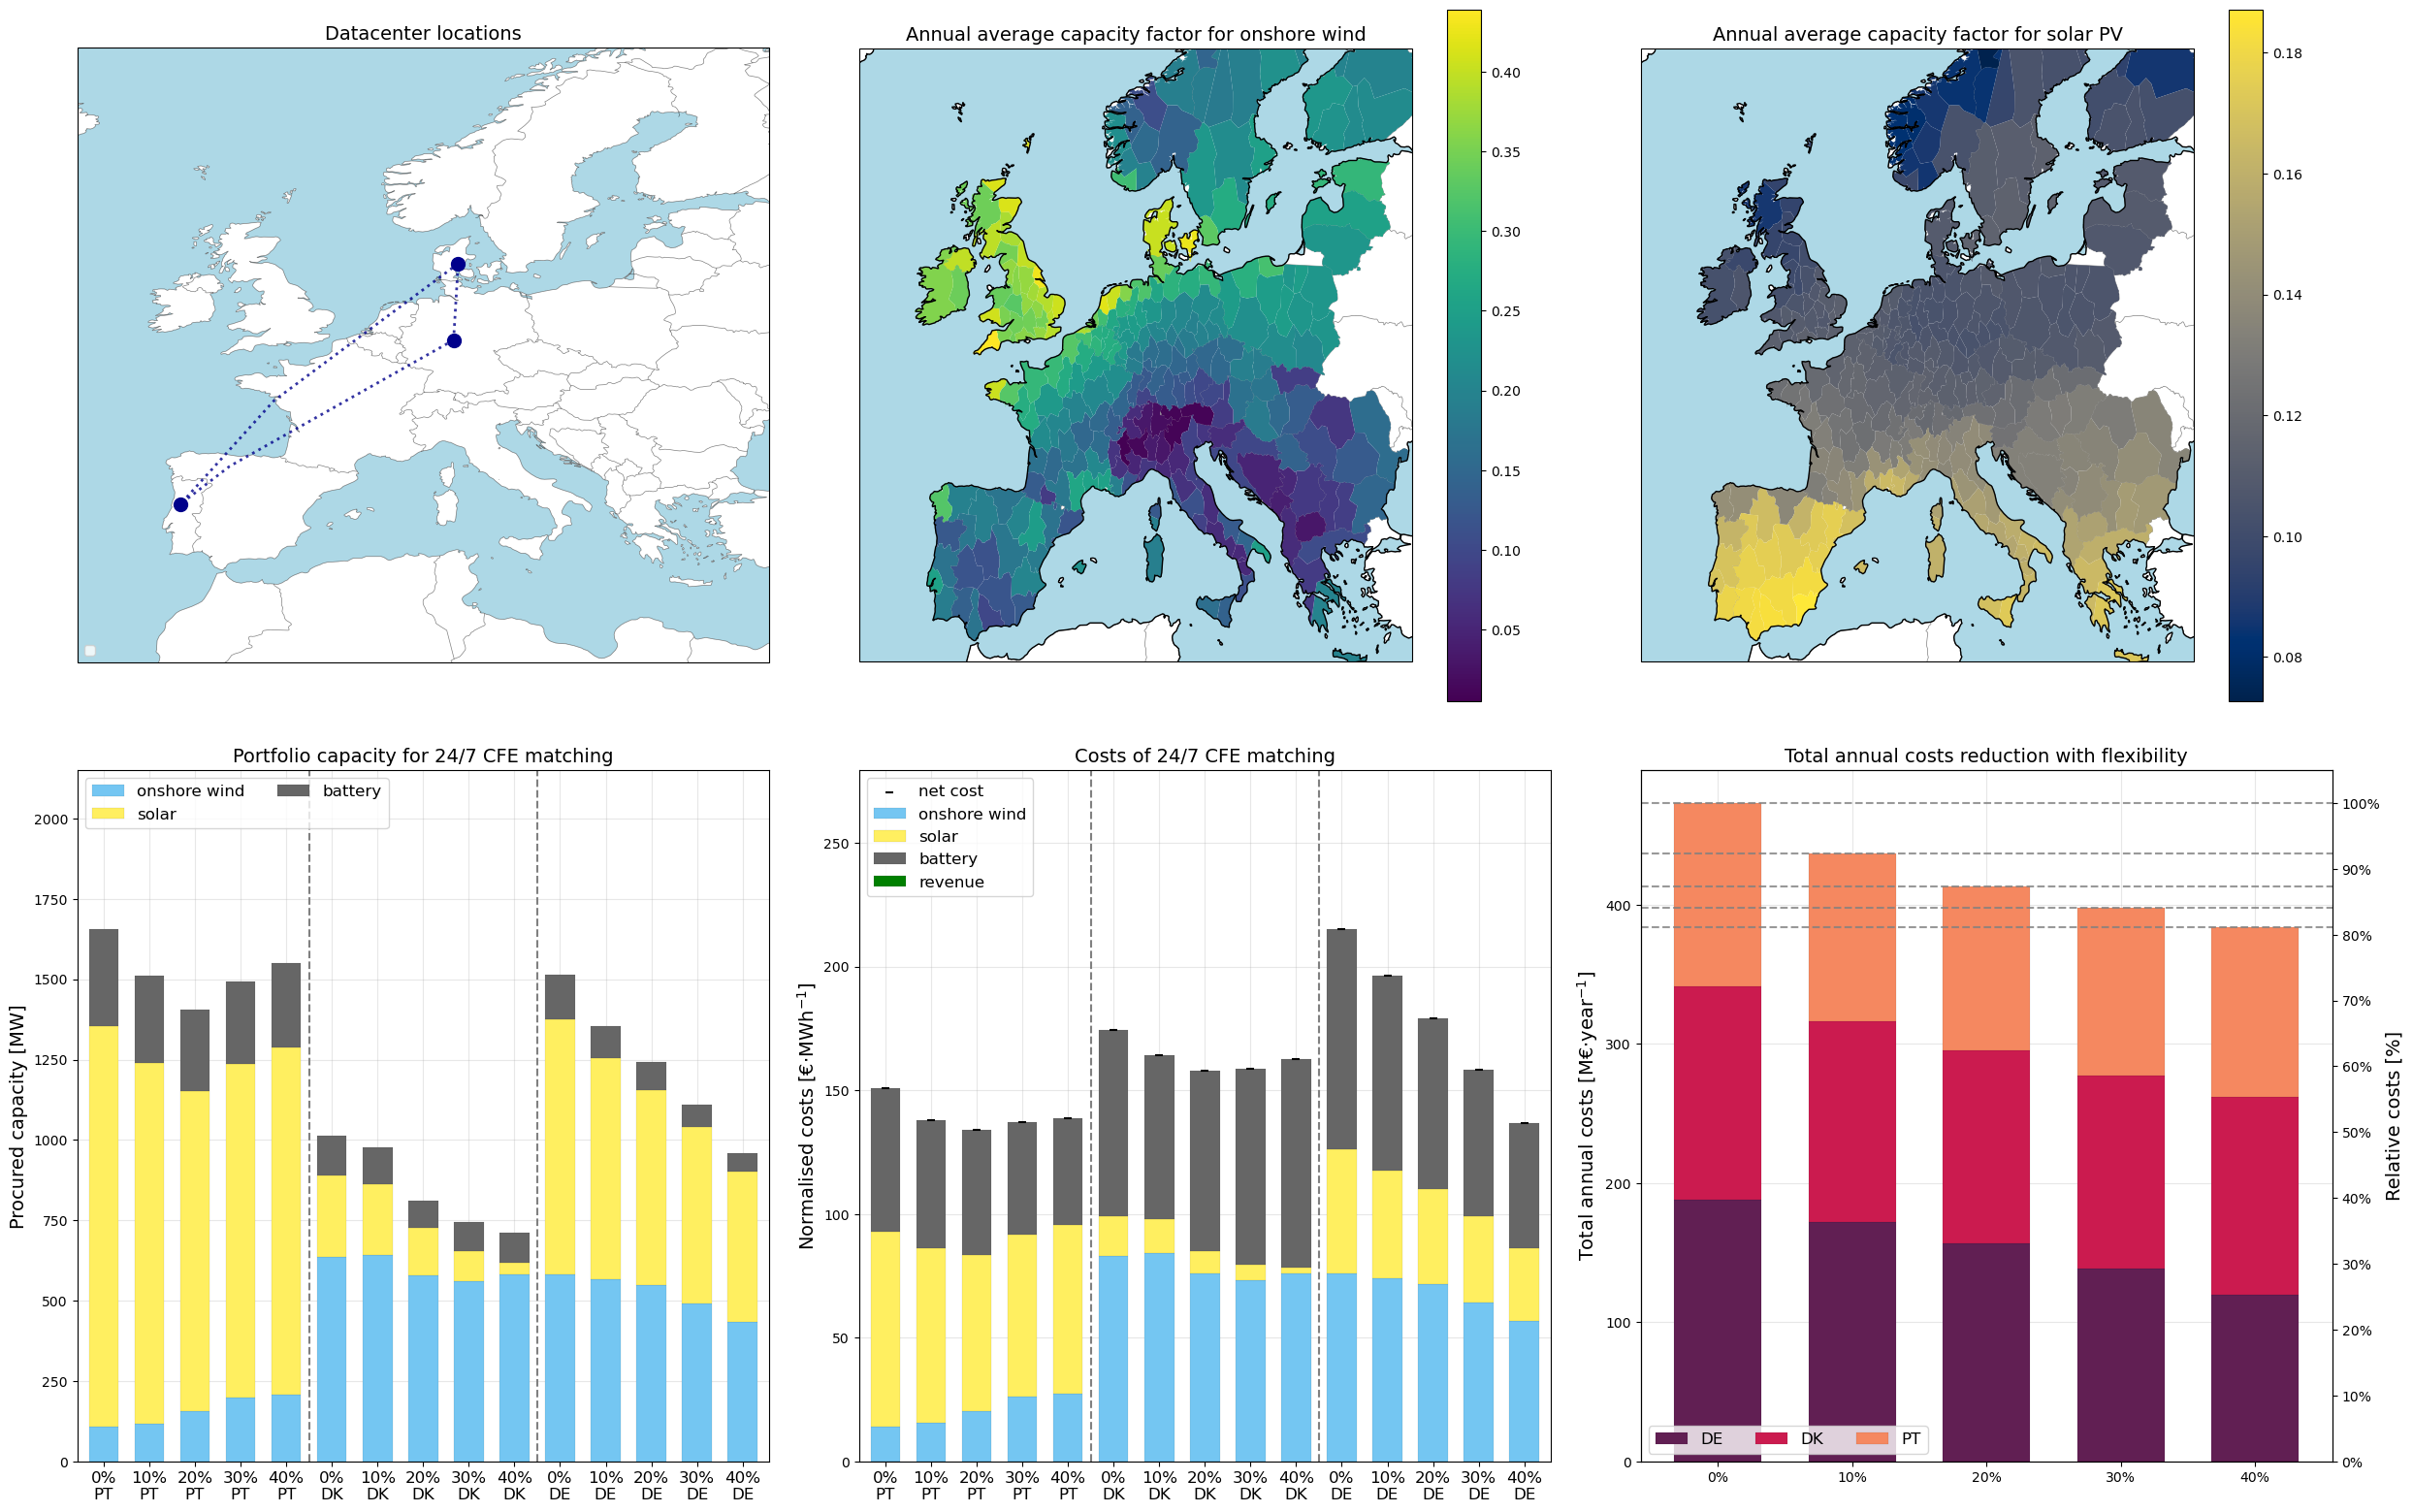

In [173]:
# Create the dashboard
create_dashboard(network=n, datacenters=datacenters, regions=regions)